In [ ]:
# Credit Risk Data Pipeline

*Convert raw bank lending data into clean, enriched features & explore key patterns.*

**Author:** Your Name  
**Date:** 2025-05-05  

In [ ]:
## 1. Setup & Imports

In [5]:
import os

# Where Jupyter thinks “.” is
print("CWD:", os.getcwd())

# What folders exist here?
print("Contents:", os.listdir("."))


CWD: /Users/danylobutynskyy/Desktop/projects/python+r/Credit Data Analysis
Contents: ['README 2.md', '.DS_Store', 'README 3.md', 'REPORT.md', '.venv', '.ipynb_checkpoints', 'data', 'Python_Whole.ipynb', 'README 1.md', 'Report копія.md', 'reports', '.idea', 'src']


In [232]:
# --- Imports & Path setup ---
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define where raw data lives and where reports/figures go
RAW_CSV    = Path("~/Desktop/projects/python+r/Credit Data Analysis/data/raw/credit_data_raw.csv").expanduser()
CLEAN_PARQ = Path("~/Desktop/projects/python+r/Credit Data Analysis/data/processed/credit_data_clean.parquet").expanduser()
OUT_DIR    = Path("~/Desktop/projects/python+r/Credit Data Analysis/reports/python").expanduser()
FIG_DIR    = OUT_DIR / "figures"

# Make sure output folders exist
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Display settings (optional)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [234]:
## 2. Data Inspection

# Load the raw CSV, examine its shape, dtypes, missingness, and duplicates.

In [236]:
# Read raw CSV (parse dates)
df = pd.read_csv(RAW_CSV, parse_dates=["issue_date"])

# Show first 5 rows
df.head()

,customer_id,issue_date,age,gender,marital_status,dependents,education_level,employment_status,annual_income,credit_score,loan_amount,term_months,interest_rate_pct,loan_purpose,home_ownership,default_12m
0,1,2023-11-15,37,Male,Married,1.0,Pflichtschule,Employed,44425.58,658,25829.27,48,7.63,Car,Rent,0
1,2,2025-04-03,36,Male,Married,0.0,Pflichtschule,Employed,53998.14,649,17444.18,36,8.59,Car,Rent,0
2,3,2024-10-03,60,Male,Married,0.0,Lehre/AHS,Retired,19813.14,661,6696.58,48,7.01,Home improvement,Mortgage,0
3,4,2024-05-23,29,Female,Single,0.0,Universität/FH,Employed,45939.59,605,6114.33,36,10.71,Furniture/Appliances,Rent,1
4,5,2023-05-04,59,Male,Single,0.0,Lehre/AHS,Retired,19617.42,743,14684.71,60,4.28,Car,Own,0


In [238]:
# Print shape and column count
print(f"Rows: {len(df)}, Columns: {df.shape[1]}")

# Show data types
print("\nDtypes:\n", df.dtypes)

# Missing value percentages
print("\nMissing (%):\n", (df.isna().mean() * 100).round(2))

# Count duplicate customer_id
dups = df.duplicated(subset="customer_id").sum()
print(f"\nDuplicate customer_id rows: {dups}")

Rows: 5050, Columns: 16

Dtypes:
 customer_id                   int64
issue_date           datetime64[ns]
age                           int64
gender                       object
marital_status               object
dependents                  float64
education_level              object
employment_status            object
annual_income               float64
credit_score                  int64
loan_amount                 float64
term_months                   int64
interest_rate_pct           float64
loan_purpose                 object
home_ownership               object
default_12m                   int64
dtype: object

Missing (%):
 customer_id          0.00
issue_date           0.00
age                  0.00
gender               0.00
marital_status       0.00
dependents           4.93
education_level      0.00
employment_status    0.00
annual_income        6.69
credit_score         0.00
loan_amount          0.00
term_months          0.00
interest_rate_pct    0.00
loan_purpose         0.

In [240]:
## 3. Data Cleaning & Feature Engineering

# 1. Fix typos & date parsing  
# 2. Impute missing values  
# 3. Cast & round numeric columns  
# 4. Create 10 new analytical features

In [242]:
# Helper: monthly annuity payment
def monthly_payment(loan_amount, annual_rate_pct, n_months):
    r = (annual_rate_pct / 100) / 12
    return (loan_amount * r) / (1 - (1 + r) ** (-n_months))

In [244]:
# 3.1 Load & clean raw data
df = pd.read_csv(RAW_CSV, parse_dates=["issue_date"])
df["issue_date"] = pd.to_datetime(df["issue_date"], errors="coerce", dayfirst=True)
df = df.drop_duplicates(subset="customer_id")

# Fix typo in employment_status
df.loc[df["employment_status"] == "Self‑empoyed", "employment_status"] = "Self‑employed"
# See exactly which “empoyed” strings remain
df["employment_status"].unique()

array(['Employed', 'Retired', 'Student', 'Self-employed', 'Part-time',
       'Unemployed', 'Other'], dtype=object)

In [246]:
# 3.2 Impute missing & cast types
df["annual_income"]   = df["annual_income"].fillna(df["annual_income"].median())
df["credit_score"]    = df["credit_score"].fillna(df["credit_score"].median())
df["dependents"]      = df["dependents"].fillna(df["dependents"].mode()[0])

df["dependents"]      = df["dependents"].astype(int)
df["credit_score"]    = df["credit_score"].astype(int)
df["loan_amount"]     = df["loan_amount"].round(2)
df["interest_rate_pct"]= df["interest_rate_pct"].round(2)

In [248]:
# 3.3 Feature engineering (10 new columns)
df["monthly_income"]       = (df["annual_income"] / 12).round(2)
df["monthly_payment"]      = monthly_payment(df["loan_amount"], df["interest_rate_pct"], df["term_months"]).round(2)
df["debt_to_income_pct"]   = (df["monthly_payment"] / df["monthly_income"] * 100).round(2)
df["loan_to_income_pct"]   = (df["loan_amount"] / df["annual_income"] * 100).round(2)
df["total_payment"]        = df["monthly_payment"] * df["term_months"]
df["total_interest"]       = df["total_payment"] - df["loan_amount"]

# ensure issue_date is in datetime64 before subtracting
df["issue_date"]           = pd.to_datetime(df["issue_date"], dayfirst=True)

df["loan_age_days"]        = (pd.to_datetime("today").normalize() - df["issue_date"]).dt.days

# re-format issue_date for display
df["issue_date"]           = df["issue_date"].dt.strftime("%d-%m-%Y")

df["age_group"]            = pd.cut(
    df["age"],
    bins=[18,25,35,45,55,65,75],
    labels=['18–25','26–35','36–45','46–55','56–65','66–75']
)

df["credit_score_band"]    = pd.cut(
    df["credit_score"],
    bins=[300,580,670,740,800,851],
    labels=["Poor","Fair","Good","Very Good","Exceptional"],
    right=False
)

#df["interest_rate_band"]   = pd.cut(
#    df["interest_rate_pct"],
#    bins=[0,7,15,100],
#    labels=["Low","Medium","High"],
#    right=False
#)

df["annual_income_band"] = pd.cut(
    df["annual_income"],
    bins=[0, 24_000, 60_000, df["annual_income"].max() + 1],
    labels=["0–24k", "24–60k", "60k+"],
    right=False
)

df["is_outlier"]           = (
    (df["loan_amount"] > 120_000) |
    (df["interest_rate_pct"] > 25)
).astype(int)

# Show new DataFrame head
df.head()



,customer_id,issue_date,age,gender,marital_status,dependents,education_level,employment_status,annual_income,credit_score,loan_amount,term_months,interest_rate_pct,loan_purpose,home_ownership,default_12m,monthly_income,monthly_payment,debt_to_income_pct,loan_to_income_pct,total_payment,total_interest,loan_age_days,age_group,credit_score_band,annual_income_band,is_outlier
0,1,15-11-2023,37,Male,Married,1,Pflichtschule,Employed,44425.58,658,25829.27,48,7.63,Car,Rent,0,3702.13,626.09,16.91,58.14,30052.32,4223.05,538,36–45,Fair,24–60k,0
1,2,03-04-2025,36,Male,Married,0,Pflichtschule,Employed,53998.14,649,17444.18,36,8.59,Car,Rent,0,4499.84,551.40,12.25,32.31,19850.40,2406.22,33,36–45,Fair,24–60k,0
2,3,03-10-2024,60,Male,Married,0,Lehre/AHS,Retired,19813.14,661,6696.58,48,7.01,Home improvement,Mortgage,0,1651.10,160.39,9.71,33.80,7698.72,1002.14,215,56–65,Fair,0–24k,0
3,4,23-05-2024,29,Female,Single,0,Universität/FH,Employed,45939.59,605,6114.33,36,10.71,Furniture/Appliances,Rent,1,3828.30,199.34,5.21,13.31,7176.24,1061.91,348,26–35,Fair,24–60k,0
4,5,04-05-2023,59,Male,Single,0,Lehre/AHS,Retired,19617.42,743,14684.71,60,4.28,Car,Own,0,1634.78,272.30,16.66,74.86,16338.00,1653.29,733,56–65,Very Good,0–24k,0


In [250]:
## 4. Save Clean Data

In [252]:
# Save to Parquet for fast reload later
df.to_parquet(CLEAN_PARQ, index=False)
print(f"✅ Cleaned data saved to {CLEAN_PARQ}")

✅ Cleaned data saved to /Users/danylobutynskyy/Desktop/projects/python+r/Credit Data Analysis/data/processed/credit_data_clean.parquet


In [254]:
## 5. Exploratory Data Analysis (EDA)

In [256]:
### 5.1 Descriptive Statistics

In [258]:
# Reload clean data
df = pd.read_parquet(CLEAN_PARQ)

# Save summary to CSV and display first few rows
summ_csv = OUT_DIR / "summary.csv"
df.describe().to_csv(summ_csv)
df.describe().head()

,customer_id,age,dependents,annual_income,credit_score,loan_amount,term_months,interest_rate_pct,default_12m,monthly_income,monthly_payment,debt_to_income_pct,loan_to_income_pct,total_payment,total_interest,loan_age_days,is_outlier
count,5050.00000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.00,5050.00,5050.000000,5050.000000,5050.000000,5050.000000
mean,2525.50000,43.468713,0.534059,39170.361117,670.026931,14438.132737,46.084752,7.658618,0.033663,3264.196978,376.889329,inf,inf,16878.477695,2440.344958,427.420990,0.000792
std,1457.95376,16.081723,0.823097,23794.695581,53.207145,8881.731204,14.416627,2.704024,0.180379,1982.891205,243.380797,NaN,NaN,11070.142968,2573.248645,253.464203,0.028136
min,1.00000,18.000000,0.000000,0.000000,470.000000,1000.000000,12.000000,1.750000,0.000000,0.000000,16.060000,0.26,0.96,1036.680000,36.680000,0.000000,0.000000
25%,1263.25000,31.000000,0.000000,23683.470000,634.000000,8335.320000,36.000000,5.490000,0.000000,1973.620000,243.892500,6.85,20.65,9463.350000,949.905000,204.000000,0.000000


In [260]:
### 5.2 Plot: Average Loan Amount by Purpose

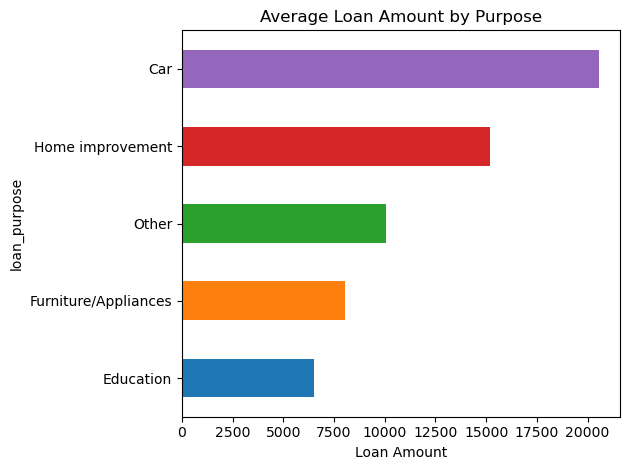

In [262]:
# Horizontal bar chart of mean loan amount by purpose
avg_loan = df.groupby("loan_purpose")["loan_amount"].mean().sort_values()

palette = sns.color_palette("tab10", n_colors=len(avg_loan))

plt.figure()
avg_loan.plot(kind="barh", color=palette)
plt.title("Average Loan Amount by Purpose")
plt.xlabel("Loan Amount")
plt.tight_layout()
plt.savefig(FIG_DIR / "loan_amount_by_purpose.png")
plt.show()

In [263]:
### 5.3 Plot: Employment Status Distribution

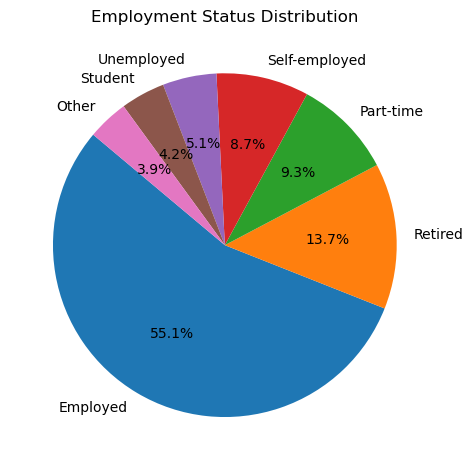

In [266]:
# Pie chart of employment status
plt.figure()
df["employment_status"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", startangle=140
)
plt.title("Employment Status Distribution")
plt.ylabel("")
plt.tight_layout()
plt.savefig(FIG_DIR / "employment_status_pie.png")
plt.show()

In [268]:
### 5.4 Plot: 4

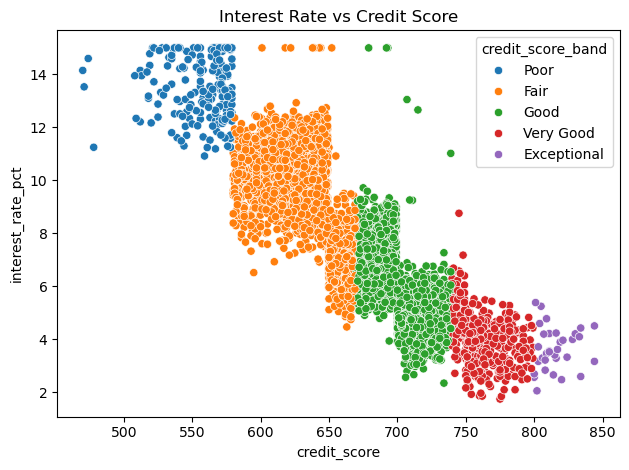

In [270]:
# Scatter plot with credit score band coloring
plt.figure()
sns.scatterplot(data=df, x="credit_score", y="interest_rate_pct", hue="credit_score_band")
plt.title("Interest Rate vs Credit Score")
plt.tight_layout()
plt.savefig(FIG_DIR / "interest_vs_credit_score.png")
plt.show()

In [271]:
### 5.5 Plot: Default Rate by Age Group

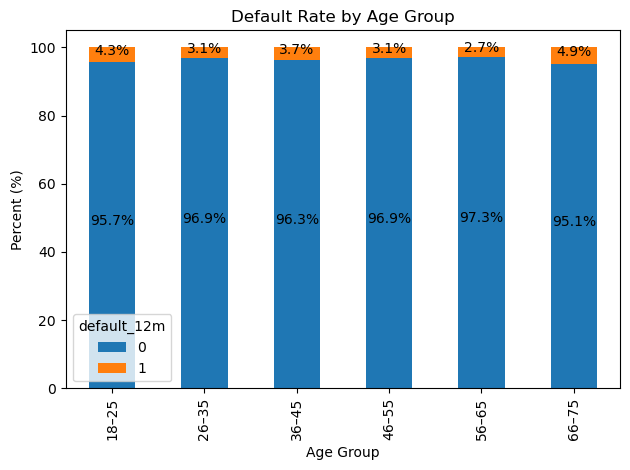

In [274]:
# Calculate percent default by age group
counts = df.groupby(["age_group","default_12m"], observed=False).size().reset_index(name="count")
total = counts.groupby("age_group", observed=False)["count"].transform("sum")
counts["percent"] = (counts["count"] / total * 100).round(1)
pivot = counts.pivot(index="age_group", columns="default_12m", values="percent").fillna(0)

# Stacked bar chart
ax = pivot.plot(kind="bar", stacked=True)
ax.set_title("Default Rate by Age Group")
ax.set_ylabel("Percent (%)")
ax.set_xlabel("Age Group")
for i, age in enumerate(pivot.index):
    bottom = 0
    for val in [0,1]:
        pct = pivot.loc[age, val]
        if pct>0:
            ax.text(i, bottom + pct/2, f"{pct:.1f}%", ha="center")
            bottom += pct

plt.tight_layout()
plt.savefig(FIG_DIR / "default_rate_by_age_group.png")
plt.show()

In [276]:
## 6. Conclusion

# - We inspected, cleaned, and enriched credit-data  
# - Generated key features (e.g. DTI, loan age, score bands)  
# - Explored patterns via summary stats and four plots  
# - **Next steps:** model default prediction, deeper cohort analysis, dashboard deployment.